# Genome Sequencing
Authors:  
- Minh Duc Ngo  
- Catharina Hoppensack  

This notebook is our own work. Any other sources have been clearly marked and cited.

All authors contributed equally.

# 1 Environment
We worked with the following environment for this jupyter notebook:

- Python version: (3.10.19) 3.11.9  
- OS: Windows 11  
- Environment: Visual Studio Code

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch
import torch.nn as nn

In [38]:


url="https://github.com/thomasmanke/DataSets/raw/refs/heads/main/labeled_sequences.csv.gz"

df = pd.read_csv(url)
seqs = df["sequence"].tolist()
y    = df["label"].values

S = len(seqs)    # number of sequences
L = len(seqs[0]) # same length for all (!!!) sequences



print(S)
print(L)

df.head()

20000
10


,sequence,label
0,GTAGGTAAGC,0
1,GGGGTATTTG,0
2,CACTTCCCTT,0
3,AATCCATAAG,0
4,GGCTTTTGCC,0


In [39]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  20000 non-null  object
 1   label     20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [40]:
print(df)
print(df.shape) #shape des DataFrames
print(df.ndim) #dimensionen des DataFrames

         sequence  label
0      GTAGGTAAGC      0
1      GGGGTATTTG      0
2      CACTTCCCTT      0
3      AATCCATAAG      0
4      GGCTTTTGCC      0
...           ...    ...
19995  GGGGTGAGAG      0
19996  ACCGCGACTA      0
19997  TCCTGCGAAT      0
19998  GATGCAGGCT      0
19999  ATCATTACGT      1

[20000 rows x 2 columns]
(20000, 2)
2


In [41]:
print(type(df))
print(type(y))
print(type(y[0]))
print(type(S))
print(type(L)) 
print(type(seqs))
print(type(seqs[0]))
print(len(df[df["label"] == 1]))
onlyOne = df[df["label"] == 1]
noDuplicates = onlyOne.drop_duplicates()
print(len(noDuplicates))


<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.int64'>
<class 'int'>
<class 'int'>
<class 'list'>
<class 'str'>
547
543


Load the dataset, inspect its structure and dimensions, and briefly describe its content.


- 20000 rows, 2 columns: sequence [object] , label [int]
- Das dataset beinhaltet Genomsequencen mit 20000 exemplare, wobei 19797 einzigartig sind. Also 203 dopplungen beinhaltet.
- Die Sequenz wird als String gespeichert und besteht aus 10 Buchstaben kombinatorisch aus A T C G, die Bauelemente der DNA
- adenosine, cytidine, guanosine, thymine
- Jedes Sequenzobjekt hat eine 1 oder eine 0 als Label
- 547 als label "1", darunter 4 Duplikate
- 2 Dimensionales df


### Task 2
Transform the data into a form suitable for MLP input:
– Convert to numpy / torch tensors
– Flatten or reshape inputs as needed
– Split into training and test sets

- flatten unnötig, sonst verliert man den überblick der infos
- reshapen nötig? Glaub nur, wenn man es für Modelle verlangt

In [ ]:
#sequenz in Nummern umwandeln, denn NN kann nur mit zahlen arbeiten
mapping = str.maketrans({'A':'1','C':'2','G':'3','T':'4'})

seqs_num = []
for seq in seqs:
    mapped = seq.translate(mapping)       #"ACGT" -> "1234"
    nums = [int(x) for x in mapped]       #-> [1,2,3,4]
    seqs_num.append(nums)


In [43]:
print(seqs_num[0:5])
print(type(seqs_num))
print(type(seqs_num[0][0]))



[[3, 4, 1, 3, 3, 4, 1, 1, 3, 2], [3, 3, 3, 3, 4, 1, 4, 4, 4, 3], [2, 1, 2, 4, 4, 2, 2, 2, 4, 4], [1, 1, 4, 2, 2, 1, 4, 1, 1, 3], [3, 3, 2, 4, 4, 4, 4, 3, 2, 2]]
<class 'list'>
<class 'int'>


In [ ]:
X = np.array(seqs_num, dtype=np.float32)
print(X.shape) #(S,L)

(20000, 10)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32)

#targets müssen float sein und 2D (N,1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)

print(f'X_train_tensor.shape: {X_train_tensor.shape}  y_train_tensor.shape: {y_train_tensor.shape}')
print(f'X_test_tensor.shape:  {X_test_tensor.shape}   y_test_tensor.shape:  {y_test_tensor.shape}')



X_train_tensor.shape: torch.Size([16000, 10])  y_train_tensor.shape: torch.Size([16000, 1])
X_test_tensor.shape:  torch.Size([4000, 10])   y_test_tensor.shape:  torch.Size([4000, 1])


### task 3
Define an appropriate MLP architecture (e.g with PyTorch nn.Sequential). Include number of layers, activation functions, and output dimensions. Report structure and number of parameters

### Multilayer Perceptron



- 2 - 3 Layer(?)
- activation function: 
    - ReLu() _ ist standard 
    - Sigmoid _ gut für binärausgaben, Wertebereich zwischen 0 - 1
    - Binary Cross Entropy

- loss func possibilities:
    - BCEWithLogitsLoss
    - MSELoss oder MAELoss
- output ist 0 oder 1 

In [47]:
#standard neural network loss function
loss_func = nn.BCEWithLogitsLoss()

#simple neural network model, 3 Layer
model = nn.Sequential(
    nn.Linear(L, 128), #input layer
    nn.ReLU(),          #standard activation function
    nn.Linear(128, 64),
    nn.ReLU(),
    #nn.droput(p=0.2),    #overfitting vermeiden, neuronen zufällig deaktivieren
    nn.Linear(64, 1)  #"Binary Classification can be realized with single output neuron" s.Vorlesungsfolien 
) #output layer
#standard neural network optimizer, lernrate 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

preparing batches? (dividing the dataset into smaller sets)

### Task 4
Implement a full training loop including:
– Loss function and optimizer
– Iterative training with loss updates
– Plot the loss history

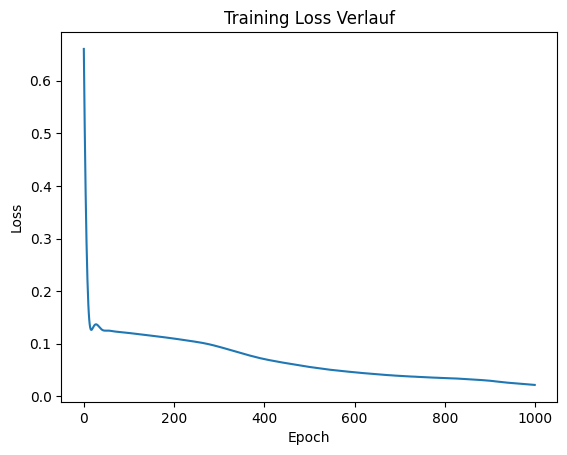

In [52]:
n_epochs = 1000
losses = []
model.train()

for epoch in range(n_epochs):
    y_pred = model(X_train_tensor)
    loss = loss_func(y_pred, y_train_tensor)
    optimizer.zero_grad()                   #Gradienten auf 0 setzen, damit sie sich nicht aufsummieren
    loss.backward()                         #Gradienten berechnen
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Verlauf")
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    y_prediction = model(X_train_tensor)                         #using test data to evaluate
    test_loss = loss_func(y_prediction, y_train_tensor).item()
print("Final train loss:", losses[-1])
print("Test loss:", test_loss)

Final train loss: 0.021821696311235428
Test loss: 0.02179361693561077


### Task 5
Generate predictions on the test set and compute suitable metrics:  
– Regression: MSE or R²  
– Classification: overall accuracy and class-wise metrices

### Task 6
Plot training and validation loss curves, and visualize model results e.g. predicted vs. true values, or confusion matrices.

### Task 7 
Provide a short reflection on model behavior and performance.